In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

import time

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [12]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df.tail()

Longitude   Latitude    NO Value  NO2 Value  BC Value
21483 -122.034943  37.560076  129.999995  44.778220  3.923761
21484 -122.034724  37.560164   60.799998  39.027545  1.408693
21485 -122.034681  37.559830   34.622951  28.816797  2.659885
21486 -122.034504  37.559958   74.764705  35.735434  1.776353
21487 -122.034503  37.559957   78.754782  41.062757  2.014664

In [13]:
df.shape

(21488, 5)

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [14]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value']]

In [15]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

In [16]:
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

In [17]:
Facility_NO2 = pd.read_csv("Data/All_NO2_Facilities_Final.csv")

## Converting facility and traffic dataframe into a geopandas dataframe for plotting

In [18]:
# Create a list of x and y coordinates for the PM facility data in Oakland using geopandas
geometry_facility_NO2 = [Point(xy) for xy in zip(Facility_NO2['longitude'], Facility_NO2['latitude'])]
geo_df_facility_NO2 = gpd.GeoDataFrame(Facility_NO2, crs = crs, geometry = geometry_facility_NO2)

In [19]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_NO2 = [Point(xy) for xy in zip(NO2_df['Longitude'], NO2_df['Latitude'])]
geo_df_NO2 = gpd.GeoDataFrame(NO2_df, crs = crs, geometry = geometry_df_NO2)

## Creating input dataframe - Method 2: 
#### In this approach, distance to each individual industry from the point of measurement, and the corresponding PM10 and PM2.5 emissions are indivudial features. Looking at the map further, industrial sources in Oakland, Piedmont and Alameda are closest to the measurement points. We filter out all other industrial sources. 

### Combining Air Pollution Monitoring Data and Facility level data

In [157]:
Facility_NO2_All = Facility_NO2.copy()

In [158]:
Facility_NO2.shape

(317, 9)

In [159]:
Facility_NO2.describe()

eis facility id    latitude   longitude  total emissions
count     3.170000e+02  317.000000  317.000000       317.000000
mean      1.192096e+07   37.784917 -122.238598         1.146599
std       6.376368e+06    0.054163    0.052545         5.263535
min       1.269110e+05   37.627747 -122.319375         0.000001
25%       1.047071e+07   37.742080 -122.275210         0.005161
50%       1.398561e+07   37.796090 -122.259300         0.023459
75%       1.724791e+07   37.817304 -122.197210         0.205630
max       1.877981e+07   37.888535 -122.094062        54.110091

In [160]:
Facility_NO2.head()

eis facility id  company name source-category  latitude  longitude  \
0           126911  PACIFIC-BELL     Institution  37.76685 -122.24972   
1           127111  PACIFIC-BELL     Institution  37.86771 -122.26784   
2           127511  PACIFIC-BELL     Institution  37.80603 -122.26946   
3           127611  PACIFIC-BELL     Institution  37.78422 -122.22241   
4           127711  PACIFIC-BELL     Institution  37.83336 -122.26307   

       city  total emissions  source-type                     geometry  
0   ALAMEDA         0.054659  Institution  POINT (-122.24972 37.76685)  
1  BERKELEY         0.162383  Institution  POINT (-122.26784 37.86771)  
2   OAKLAND         0.619550  Institution  POINT (-122.26946 37.80603)  
3   OAKLAND         0.052783  Institution  POINT (-122.22241 37.78422)  
4   OAKLAND         0.116122  Institution  POINT (-122.26307 37.83336)

In [161]:
Facility_NO2.rename(columns = {'total emissions':'NO2'}, inplace=True)

In [162]:
### Create a columns as eis-source-type
Facility_NO2['eis-source'] =  Facility_NO2['source-type']+ '-' + Facility_NO2['eis facility id'].apply(str) 

In [163]:
### Add an empty column for distance
Facility_NO2['dist'] = 0
Facility_NO2['dist'].astype(float)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
322    0.0
323    0.0
324    0.0
325    0.0
326    0.0
Name: dist, Length: 317, dtype: float64

### Add a column for emissions/distance since concentration is directly proportional to emissions and inversely proportional to distance from soure

In [164]:
Facility_NO2['emsdist'] = 0
Facility_NO2['emsdist'].astype(float)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
322    0.0
323    0.0
324    0.0
325    0.0
326    0.0
Name: emsdist, Length: 317, dtype: float64

In [165]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(Facility_NO2['longitude'], Facility_NO2['latitude'])]

In [166]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(Facility_NO2, crs = crs, geometry = geometry_facility)

#### Plotting only industrial facilities in the area

In [167]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [168]:
oakl.crs

{'init': 'epsg:4326'}

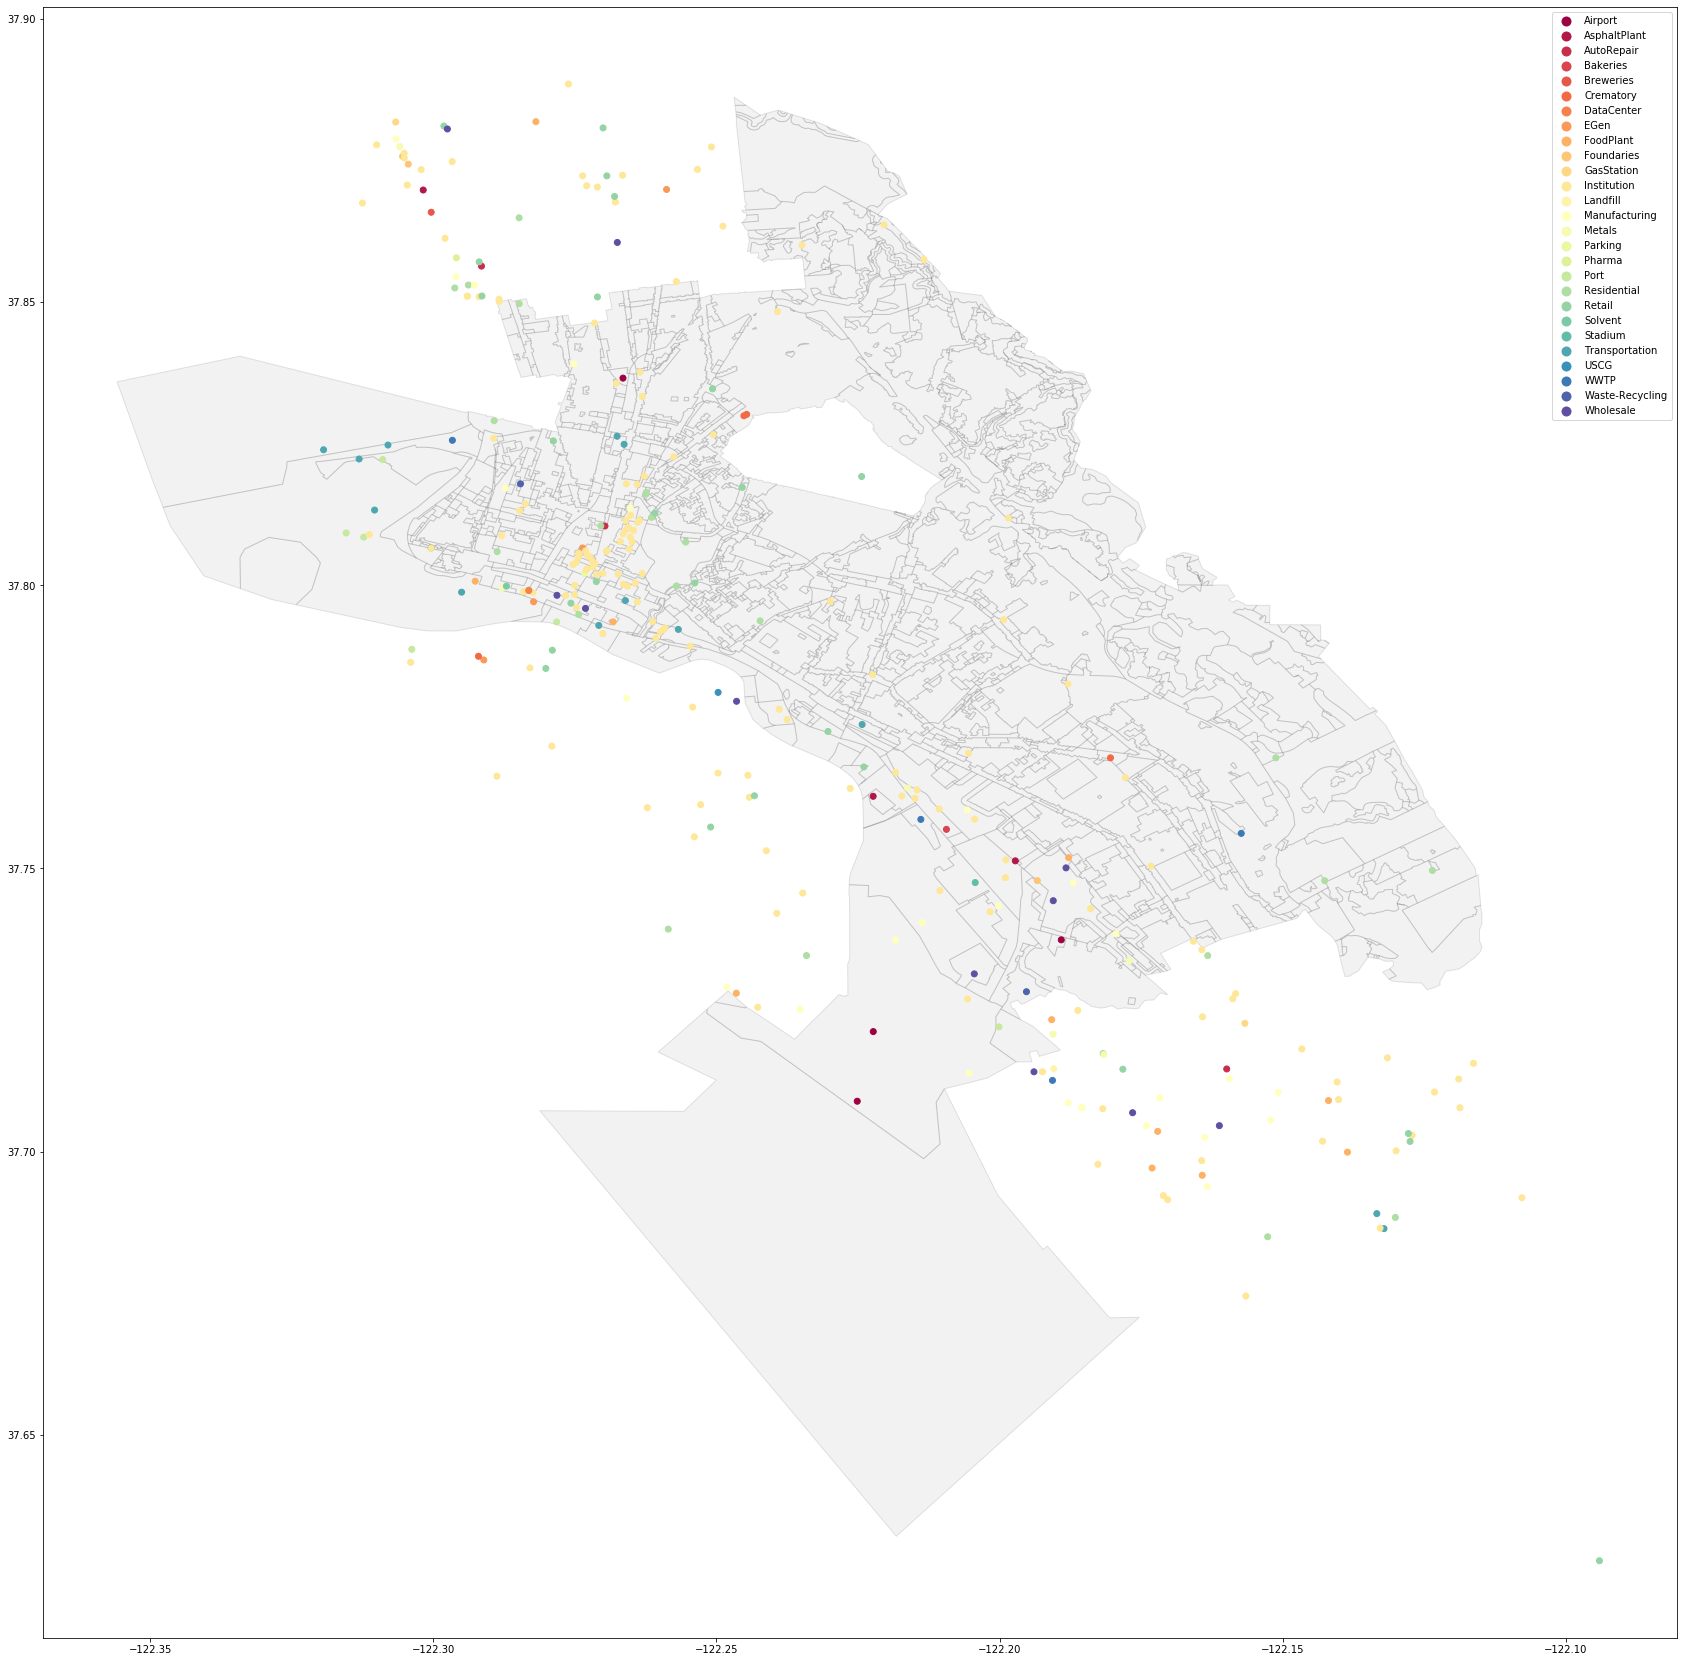

In [211]:
fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility.plot(ax=ax, cmap = 'Spectral', column = 'source-type', legend = True)
#plt.legend(handles=[maroon_D, orange_D, yellow_D, darkviolet_D ,green_D, blue_D, fuchsia_D, black_D, red_D,cyan_D,
#                   peru_D, palegreen_D, pink_D, dimgrey_D, gold_D, dodgerblue_D, forestgreen_D, slateblue_D])

plt.show()

#### Create a dataframe where each column is one of the industrial facilities, with columns as latitude, longitude, NO2 emissions value and geometry.

In [170]:
NO2_lat = Facility_NO2[['eis-source', 'latitude']]
NO2_long = Facility_NO2[['eis-source', 'longitude']]
NO2_NO2 = Facility_NO2[['eis-source', 'NO2']]
NO2_dist = Facility_NO2[['eis-source', 'dist']]
NO2_emsdist = Facility_NO2[['eis-source', 'emsdist']]
NO2_geo = Facility_NO2[['eis-source', 'geometry']]


In [171]:
# Transpose all the dataframes
NO2_lat = NO2_lat.T
NO2_long = NO2_long.T
NO2_NO2 = NO2_NO2.T
NO2_dist = NO2_dist.T
NO2_emsdist = NO2_emsdist.T
NO2_geo = NO2_geo.T

In [172]:
## Make the header as the first row in each transposed dataframe
NO2_lat = NO2_lat.rename(columns=NO2_lat.iloc[0]).drop(NO2_lat.index[0])
NO2_long = NO2_long.rename(columns=NO2_long.iloc[0]).drop(NO2_long.index[0])
NO2_NO2 = NO2_NO2.rename(columns=NO2_NO2.iloc[0]).drop(NO2_NO2.index[0])
NO2_dist = NO2_dist.rename(columns=NO2_dist.iloc[0]).drop(NO2_dist.index[0])
NO2_emsdist = NO2_emsdist.rename(columns=NO2_emsdist.iloc[0]).drop(NO2_emsdist.index[0])
NO2_geo = NO2_geo.rename(columns=NO2_geo.iloc[0]).drop(NO2_geo.index[0])

In [173]:
## Add suffix to column header based on the dataframe type
NO2_lat.columns = [str(col) + '_latitude' for col in NO2_lat.columns]
NO2_long.columns = [str(col) + '_longitude' for col in NO2_long.columns]
NO2_NO2.columns = [str(col) + '_NO2' for col in NO2_NO2.columns]
NO2_dist.columns = [str(col) + '_dist' for col in NO2_dist.columns]
NO2_emsdist.columns = [str(col) + '_emsdist' for col in NO2_emsdist.columns]
NO2_geo.columns = [str(col) + '_geo' for col in NO2_geo.columns]

In [174]:
## Remove index for each dataframe
NO2_lat.reset_index(drop=True, inplace=True)
NO2_long.reset_index(drop=True, inplace=True)
NO2_NO2.reset_index(drop=True, inplace=True)
NO2_dist.reset_index(drop=True, inplace=True)
NO2_emsdist.reset_index(drop=True, inplace=True)
NO2_geo.reset_index(drop=True, inplace=True)

In [175]:
NO2_combined = NO2_lat.join(NO2_long).join(NO2_NO2).join(NO2_dist).join(NO2_emsdist).join(NO2_geo)


In [176]:
NO2_combined

Institution-126911_latitude Institution-127111_latitude  \
0                     37.7668                     37.8677   

  Institution-127511_latitude Institution-127611_latitude  \
0                      37.806                     37.7842   

  Institution-127711_latitude Institution-127811_latitude  \
0                     37.8334                     37.8119   

  Institution-128211_latitude Institution-130511_latitude  \
0                     37.7001                     37.7605   

  EGen-136511_latitude Institution-137211_latitude  ...  \
0              37.7868                     37.8227  ...   

        Institution-18545211_geo       Institution-18545511_geo  \
0  POINT (-122.274368 37.805031)  POINT (-122.270046 37.802128)   

        Institution-18545611_geo      Residential-18697111_geo  \
0  POINT (-122.265518 37.810242)  POINT (-122.27432 37.794834)   

          Wholesale-18697211_geo            Retail-18697311_geo  \
0  POINT (-122.273125 37.795936)  POINT (-122.178222 37.714556)   

          Wholesale-18697911_geo          Metals-18698311_geo  \
0  POINT (-122.190515 37.744311)  POINT (-122.18159 37.71716)   

     Manufacturing-18776511_geo  Manufacturing-18779811_geo  
0  POINT (-122.29271 37.853018)  POINT (-122.1855 37.70782)  

[1 rows x 1902 columns]

In [177]:
NO2_combined = NO2_combined.reindex(columns=sorted(NO2_combined.columns))

In [178]:
NO2_combined

Airport-10490111_NO2 Airport-10490111_dist Airport-10490111_emsdist  \
0             0.120264                     0                        0   

         Airport-10490111_geo Airport-10490111_latitude  \
0  POINT (-122.22513 37.7089)                   37.7089   

  Airport-10490111_longitude Airport-11650611_NO2 Airport-11650611_dist  \
0                   -122.225            0.0059268                     0   

  Airport-11650611_emsdist       Airport-11650611_geo  ...  \
0                        0  POINT (-122.2665 37.8366)  ...   

  Wholesale-18697211_emsdist         Wholesale-18697211_geo  \
0                          0  POINT (-122.273125 37.795936)   

  Wholesale-18697211_latitude Wholesale-18697211_longitude  \
0                     37.7959                     -122.273   

  Wholesale-18697911_NO2 Wholesale-18697911_dist Wholesale-18697911_emsdist  \
0               0.803283                       0                          0   

          Wholesale-18697911_geo Wholesale-18697911_latitude  \
0  POINT (-122.190515 37.744311)                     37.7443   

  Wholesale-18697911_longitude  
0                     -122.191  

[1 rows x 1902 columns]

In [179]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
NO2_combined = NO2_combined.loc[NO2_combined.index.repeat(21488)].reset_index(drop=True)

In [180]:
NO2_Facility = NO2_df.join(NO2_combined)

In [181]:
# Convert distance column to float type
for idx, col in enumerate(NO2_Facility.columns):
        if "_dist" in col:
            NO2_Facility[col] = pd.to_numeric(NO2_Facility[col], downcast="float")


### Calculate distance between point of measurement and each facility and add it to the _dist column

In [182]:
### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [183]:
NO2_Facility.head()

Longitude   Latitude  NO2 Value                     geometry  \
0 -122.322594  37.806781  17.539762  POINT (-122.32259 37.80678)   
1 -122.322310  37.806150  19.956750  POINT (-122.32231 37.80615)   
2 -122.322301  37.806420  23.967768  POINT (-122.32230 37.80642)   
3 -122.322299  37.805880  18.435184  POINT (-122.32230 37.80588)   
4 -122.322267  37.806689  25.797037  POINT (-122.32227 37.80669)   

  Airport-10490111_NO2  Airport-10490111_dist Airport-10490111_emsdist  \
0             0.120264                    0.0                        0   
1             0.120264                    0.0                        0   
2             0.120264                    0.0                        0   
3             0.120264                    0.0                        0   
4             0.120264                    0.0                        0   

         Airport-10490111_geo Airport-10490111_latitude  \
0  POINT (-122.22513 37.7089)                   37.7089   
1  POINT (-122.22513 37.7089)                   37.7089   
2  POINT (-122.22513 37.7089)                   37.7089   
3  POINT (-122.22513 37.7089)                   37.7089   
4  POINT (-122.22513 37.7089)                   37.7089   

  Airport-10490111_longitude  ... Wholesale-18697211_emsdist  \
0                   -122.225  ...                          0   
1                   -122.225  ...                          0   
2                   -122.225  ...                          0   
3                   -122.225  ...                          0   
4                   -122.225  ...                          0   

          Wholesale-18697211_geo Wholesale-18697211_latitude  \
0  POINT (-122.273125 37.795936)                     37.7959   
1  POINT (-122.273125 37.795936)                     37.7959   
2  POINT (-122.273125 37.795936)                     37.7959   
3  POINT (-122.273125 37.795936)                     37.7959   
4  POINT (-122.273125 37.795936)                     37.7959   

  Wholesale-18697211_longitude Wholesale-18697911_NO2 Wholesale-18697911_dist  \
0                     -122.273               0.803283                     0.0   
1                     -122.273               0.803283                     0.0   
2                     -122.273               0.803283                     0.0   
3                     -122.273               0.803283                     0.0   
4                     -122.273               0.803283                     0.0   

  Wholesale-18697911_emsdist         Wholesale-18697911_geo  \
0                          0  POINT (-122.190515 37.744311)   
1                          0  POINT (-122.190515 37.744311)   
2                          0  POINT (-122.190515 37.744311)   
3                          0  POINT (-122.190515 37.744311)   
4                          0  POINT (-122.190515 37.744311)   

  Wholesale-18697911_latitude Wholesale-18697911_longitude  
0                     37.7443                     -122.191  
1                     37.7443                     -122.191  
2                     37.7443                     -122.191  
3                     37.7443                     -122.191  
4                     37.7443                     -122.191  

[5 rows x 1906 columns]

### Calculating distance between each industrial facility and the point of measurement

In [184]:
time1 = time.time()
for index, row in NO2_Facility.iterrows():
    for idx, col in enumerate(NO2_Facility.columns):
        if "_dist" in col:
            NO2_Facility.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+3], row.iloc[idx+4])))*0.621
            #BC_Facility.at[index,col] = float(row.iloc[idx])
time2 = time.time()            
    
print(time2 - time1)


250.09402060508728


In [185]:
NO2_Facility.tail()

Longitude   Latitude  NO2 Value                     geometry  \
21483 -122.034943  37.560076  44.778220  POINT (-122.03494 37.56008)   
21484 -122.034724  37.560164  39.027545  POINT (-122.03472 37.56016)   
21485 -122.034681  37.559830  28.816797  POINT (-122.03468 37.55983)   
21486 -122.034504  37.559958  35.735434  POINT (-122.03450 37.55996)   
21487 -122.034503  37.559957  41.062757  POINT (-122.03450 37.55996)   

      Airport-10490111_NO2  Airport-10490111_dist Airport-10490111_emsdist  \
21483             0.120264              14.620950                        0   
21484             0.120264              14.625196                        0   
21485             0.120264              14.643068                        0   
21486             0.120264              14.643760                        0   
21487             0.120264              14.643794                        0   

             Airport-10490111_geo Airport-10490111_latitude  \
21483  POINT (-122.22513 37.7089)                   37.7089   
21484  POINT (-122.22513 37.7089)                   37.7089   
21485  POINT (-122.22513 37.7089)                   37.7089   
21486  POINT (-122.22513 37.7089)                   37.7089   
21487  POINT (-122.22513 37.7089)                   37.7089   

      Airport-10490111_longitude  ... Wholesale-18697211_emsdist  \
21483                   -122.225  ...                          0   
21484                   -122.225  ...                          0   
21485                   -122.225  ...                          0   
21486                   -122.225  ...                          0   
21487                   -122.225  ...                          0   

              Wholesale-18697211_geo Wholesale-18697211_latitude  \
21483  POINT (-122.273125 37.795936)                     37.7959   
21484  POINT (-122.273125 37.795936)                     37.7959   
21485  POINT (-122.273125 37.795936)                     37.7959   
21486  POINT (-122.273125 37.795936)                     37.7959   
21487  POINT (-122.273125 37.795936)                     37.7959   

      Wholesale-18697211_longitude Wholesale-18697911_NO2  \
21483                     -122.273               0.803283   
21484                     -122.273               0.803283   
21485                     -122.273               0.803283   
21486                     -122.273               0.803283   
21487                     -122.273               0.803283   

      Wholesale-18697911_dist Wholesale-18697911_emsdist  \
21483               15.303072                          0   
21484               15.304677                          0   
21485               15.325130                          0   
21486               15.323191                          0   
21487               15.323225                          0   

              Wholesale-18697911_geo Wholesale-18697911_latitude  \
21483  POINT (-122.190515 37.744311)                     37.7443   
21484  POINT (-122.190515 37.744311)                     37.7443   
21485  POINT (-122.190515 37.744311)                     37.7443   
21486  POINT (-122.190515 37.744311)                     37.7443   
21487  POINT (-122.190515 37.744311)                     37.7443   

      Wholesale-18697911_longitude  
21483                     -122.191  
21484                     -122.191  
21485                     -122.191  
21486                     -122.191  
21487                     -122.191  

[5 rows x 1906 columns]

### Calculate a column as emission PM25 / Dist to use as the feature in the model

In [186]:
time1 = time.time()
for index, row in NO2_Facility.iterrows():
    for idx, col in enumerate(NO2_Facility.columns):
        if "_emsdist" in col:
            try:
                NO2_Facility.at[index,col] = (row.iloc[idx-2]/row.iloc[idx-1])
            except ZeroDivisionError:
                NO2_Facility.at[index,col] = 0
time2 = time.time()            
    
print(time2 - time1)


145.98190569877625


In [187]:
### Write this to a dataframe
NO2_Facility.to_csv("Data/NO2_Facility_EmsDist_ALL.csv")

##### Drop latitude, longitude and emissions since we don't need those columns. Latitude and longitude values are captured in the distance column. Since all the emissions values are the same, that feature would not be important

In [188]:
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('_dist', case=False)] 
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('_NO2', case=False)] 
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('_latitude', case=False)]
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('_longitude', case=False)] 
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('_geo', case=False)] 
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('geometry', case=False)] 
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('Longitude', case=False)] 
NO2_Facility = NO2_Facility.loc[:,~NO2_Facility.columns.str.contains('Latitude', case=False)] 

In [189]:
NO2_Facility.head()

NO2 Value Airport-10490111_emsdist Airport-11650611_emsdist  \
0  17.539762                0.0139811               0.00160704   
1  19.956750                0.0140526               0.00160193   
2  23.967768                0.0140291               0.00160671   
3  18.435184                0.0140773               0.00159756   
4  25.797037                0.0140071               0.00161194   

  Airport-13761511_emsdist Airport-13777411_emsdist  \
0               0.00660214               0.00508116   
1               0.00663711               0.00510269   
2               0.00662609               0.00509695   
3               0.00664877               0.00510898   
4                0.0066159               0.00509189   

  AsphaltPlant-10510811_emsdist AsphaltPlant-200311_emsdist  \
0                       1.50136                   0.0105746   
1                        1.5097                   0.0106216   
2                       1.50763                   0.0106099   
3                         1.512                   0.0106346   
4                       1.50584                   0.0105998   

  AsphaltPlant-808611_emsdist AutoRepair-195711_emsdist  \
0                    0.378678                 0.0576422   
1                     0.37548                 0.0571591   
2                    0.376993                 0.0574124   
3                    0.374003                  0.056915   
4                    0.378538                 0.0576753   

  AutoRepair-375611_emsdist  ... Wholesale-17244511_emsdist  \
0                 0.0141364  ...                    1.52556   
1                 0.0141914  ...                    1.53089   
2                 0.0142031  ...                    1.52936   
3                 0.0141845  ...                    1.53253   
4                 0.0142207  ...                    1.52798   

  Wholesale-17250611_emsdist Wholesale-17252511_emsdist  \
0                 0.00413254                0.000437728   
1                 0.00417441                0.000439531   
2                 0.00416817                0.000439091   
3                 0.00418227                0.000440022   
4                 0.00416394                0.000438715   

  Wholesale-18129211_emsdist Wholesale-18130011_emsdist  \
0                0.000639897                3.34036e-06   
1                0.000642652                3.31641e-06   
2                0.000641827                3.32778e-06   
3                0.000643534                3.30529e-06   
4                0.000641073                3.33939e-06   

  Wholesale-18132011_emsdist Wholesale-18135811_emsdist  \
0                0.000754956                   0.208529   
1                0.000758558                   0.209326   
2                0.000757521                   0.209092   
3                0.000759675                   0.209578   
4                0.000756585                   0.208878   

  Wholesale-18539511_emsdist Wholesale-18697211_emsdist  \
0                 0.00340647                   0.116544   
1                 0.00338924                   0.117648   
2                 0.00339979                   0.117466   
3                 0.00337922                   0.117872   
4                 0.00341094                   0.117334   

  Wholesale-18697911_emsdist  
0                  0.0956188  
1                  0.0960254  
2                  0.0959211  
3                  0.0961406  
4                  0.0958303  

[5 rows x 318 columns]

In [191]:
NO2_Facility.to_csv("Data/NO2_Facility_EmsDist_Inputs.csv")

In [192]:
NO2_Facility.head()

NO2 Value Airport-10490111_emsdist Airport-11650611_emsdist  \
0  17.539762                0.0139811               0.00160704   
1  19.956750                0.0140526               0.00160193   
2  23.967768                0.0140291               0.00160671   
3  18.435184                0.0140773               0.00159756   
4  25.797037                0.0140071               0.00161194   

  Airport-13761511_emsdist Airport-13777411_emsdist  \
0               0.00660214               0.00508116   
1               0.00663711               0.00510269   
2               0.00662609               0.00509695   
3               0.00664877               0.00510898   
4                0.0066159               0.00509189   

  AsphaltPlant-10510811_emsdist AsphaltPlant-200311_emsdist  \
0                       1.50136                   0.0105746   
1                        1.5097                   0.0106216   
2                       1.50763                   0.0106099   
3                         1.512                   0.0106346   
4                       1.50584                   0.0105998   

  AsphaltPlant-808611_emsdist AutoRepair-195711_emsdist  \
0                    0.378678                 0.0576422   
1                     0.37548                 0.0571591   
2                    0.376993                 0.0574124   
3                    0.374003                  0.056915   
4                    0.378538                 0.0576753   

  AutoRepair-375611_emsdist  ... Wholesale-17244511_emsdist  \
0                 0.0141364  ...                    1.52556   
1                 0.0141914  ...                    1.53089   
2                 0.0142031  ...                    1.52936   
3                 0.0141845  ...                    1.53253   
4                 0.0142207  ...                    1.52798   

  Wholesale-17250611_emsdist Wholesale-17252511_emsdist  \
0                 0.00413254                0.000437728   
1                 0.00417441                0.000439531   
2                 0.00416817                0.000439091   
3                 0.00418227                0.000440022   
4                 0.00416394                0.000438715   

  Wholesale-18129211_emsdist Wholesale-18130011_emsdist  \
0                0.000639897                3.34036e-06   
1                0.000642652                3.31641e-06   
2                0.000641827                3.32778e-06   
3                0.000643534                3.30529e-06   
4                0.000641073                3.33939e-06   

  Wholesale-18132011_emsdist Wholesale-18135811_emsdist  \
0                0.000754956                   0.208529   
1                0.000758558                   0.209326   
2                0.000757521                   0.209092   
3                0.000759675                   0.209578   
4                0.000756585                   0.208878   

  Wholesale-18539511_emsdist Wholesale-18697211_emsdist  \
0                 0.00340647                   0.116544   
1                 0.00338924                   0.117648   
2                 0.00339979                   0.117466   
3                 0.00337922                   0.117872   
4                 0.00341094                   0.117334   

  Wholesale-18697911_emsdist  
0                  0.0956188  
1                  0.0960254  
2                  0.0959211  
3                  0.0961406  
4                  0.0958303  

[5 rows x 318 columns]

In [210]:
NO2_Facility.head()

NO2 Value Airport-10490111_emsdist Airport-11650611_emsdist  \
0  17.539762                0.0139811               0.00160704   
1  19.956750                0.0140526               0.00160193   
2  23.967768                0.0140291               0.00160671   
3  18.435184                0.0140773               0.00159756   
4  25.797037                0.0140071               0.00161194   

  Airport-13761511_emsdist Airport-13777411_emsdist  \
0               0.00660214               0.00508116   
1               0.00663711               0.00510269   
2               0.00662609               0.00509695   
3               0.00664877               0.00510898   
4                0.0066159               0.00509189   

  AsphaltPlant-10510811_emsdist AsphaltPlant-200311_emsdist  \
0                       1.50136                   0.0105746   
1                        1.5097                   0.0106216   
2                       1.50763                   0.0106099   
3                         1.512                   0.0106346   
4                       1.50584                   0.0105998   

  AsphaltPlant-808611_emsdist AutoRepair-195711_emsdist  \
0                    0.378678                 0.0576422   
1                     0.37548                 0.0571591   
2                    0.376993                 0.0574124   
3                    0.374003                  0.056915   
4                    0.378538                 0.0576753   

  AutoRepair-375611_emsdist  ... Wholesale-17244511_emsdist  \
0                 0.0141364  ...                    1.52556   
1                 0.0141914  ...                    1.53089   
2                 0.0142031  ...                    1.52936   
3                 0.0141845  ...                    1.53253   
4                 0.0142207  ...                    1.52798   

  Wholesale-17250611_emsdist Wholesale-17252511_emsdist  \
0                 0.00413254                0.000437728   
1                 0.00417441                0.000439531   
2                 0.00416817                0.000439091   
3                 0.00418227                0.000440022   
4                 0.00416394                0.000438715   

  Wholesale-18129211_emsdist Wholesale-18130011_emsdist  \
0                0.000639897                3.34036e-06   
1                0.000642652                3.31641e-06   
2                0.000641827                3.32778e-06   
3                0.000643534                3.30529e-06   
4                0.000641073                3.33939e-06   

  Wholesale-18132011_emsdist Wholesale-18135811_emsdist  \
0                0.000754956                   0.208529   
1                0.000758558                   0.209326   
2                0.000757521                   0.209092   
3                0.000759675                   0.209578   
4                0.000756585                   0.208878   

  Wholesale-18539511_emsdist Wholesale-18697211_emsdist  \
0                 0.00340647                   0.116544   
1                 0.00338924                   0.117648   
2                 0.00339979                   0.117466   
3                 0.00337922                   0.117872   
4                 0.00341094                   0.117334   

  Wholesale-18697911_emsdist  
0                  0.0956188  
1                  0.0960254  
2                  0.0959211  
3                  0.0961406  
4                  0.0958303  

[5 rows x 318 columns]